# An√°lise de Dados: Redu√ß√£o de Rotatividade de Funcion√°rios (Churn)

## Objetivo de Neg√≥cio
Analisar o dataset de rotatividade de funcion√°rios para identificar os principais fatores que influenciam a sa√≠da, desenvolver um modelo preditivo para identificar colaboradores em risco e propor um plano de a√ß√£o para reter talentos, visando reduzir os custos associados ao turnover.

## Contexto
A alta rotatividade de funcion√°rios gera custos significativos com recrutamento, treinamento e perda de produtividade. A diretoria busca uma an√°lise baseada em dados para tomar decis√µes estrat√©gicas e proativas na gest√£o de talentos.

## Framework DDPP
Esta an√°lise seguir√° rigorosamente o framework DDPP:
- **Descritiva**: O que aconteceu?
- **Diagn√≥stica**: Por que aconteceu?
- **Preditiva**: O que vai acontecer?
- **Prescritiva**: O que devemos fazer?


In [1]:
# Importa√ß√£o das bibliotecas necess√°rias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Configura√ß√µes
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Criar diret√≥rios se n√£o existirem
if not os.path.exists('outputs'):
    os.makedirs('outputs')
    print("Diret√≥rio 'outputs' criado com sucesso!")

if not os.path.exists('modelos'):
    os.makedirs('modelos')
    print("Diret√≥rio 'modelos' criado com sucesso!")

# Fun√ß√£o para salvar gr√°ficos
def save_plot(filename, dpi=300, bbox_inches='tight'):
    plt.savefig(f'outputs/{filename}', dpi=dpi, bbox_inches=bbox_inches)
    plt.show()

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# Carregamento e primeira visualiza√ß√£o dos dados
df = pd.read_csv('employee_churn_data.csv')

print("Dataset carregado com sucesso!")
print(f"Dimens√µes do dataset: {df.shape}")
print("\nPrimeiras 5 linhas:")
df.head()

Dataset carregado com sucesso!
Dimens√µes do dataset: (9540, 10)

Primeiras 5 linhas:


department  promoted    review  projects  salary  tenure  satisfaction  \
0  operations         0  0.577569         3     low     5.0      0.626759   
1  operations         0  0.751900         3  medium     6.0      0.443679   
2     support         0  0.722548         3  medium     6.0      0.446823   
3   logistics         0  0.675158         4    high     8.0      0.440139   
4       sales         0  0.676203         3    high     5.0      0.577607   

   bonus  avg_hrs_month left  
0      0     180.866070   no  
1      0     182.708149   no  
2      0     184.416084   no  
3      0     188.707545   no  
4      1     179.821083   no

---
# Fase 1: An√°lise Descritiva

## Objetivo da Fase
Nesta fase, o objetivo √© entender o estado atual da rotatividade, calculando a taxa geral e explorando as distribui√ß√µes das principais vari√°veis. Buscaremos responder: "O que est√° acontecendo com a rotatividade na empresa?"

In [3]:
# Mapeamento das colunas para nomes mais descritivos
column_mapping = {
    'satisfaction': 'satisfaction',
    'evaluation': 'review', 
    'number_of_projects': 'projects',
    'average_monthly_hours': 'avg_hrs_month',
    'tenure': 'tenure',
    'work_accident': 'work_accident',
    'promotion_last_5years': 'promoted',
    'department': 'department',
    'salary': 'salary',
    'left': 'left'
}

# Renomear colunas se necess√°rio
df = df.rename(columns=column_mapping)

# Adicionar coluna 'bonus' se n√£o existir (baseada em heur√≠stica)
if 'bonus' not in df.columns:
    # Criar vari√°vel bonus baseada em combina√ß√£o de fatores
    df['bonus'] = ((df['promoted'] == 1) | 
                   (df['review'] > 0.8) | 
                   (df['salary'] == 'high')).astype(int)

print("Estrutura do dataset ap√≥s ajustes:")
print(df.info())

Estrutura do dataset ap√≥s ajustes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB
None


In [4]:
# An√°lise de dados faltantes
print("An√°lise de dados faltantes:")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Valores Faltantes': missing_data,
    'Percentual (%)': missing_percentage
})
missing_summary = missing_summary[missing_summary['Valores Faltantes'] > 0]
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("N√£o h√° dados faltantes no dataset.")

# Estat√≠sticas descritivas
print("\nEstat√≠sticas descritivas das vari√°veis num√©ricas:")
df.describe()

An√°lise de dados faltantes:
N√£o h√° dados faltantes no dataset.

Estat√≠sticas descritivas das vari√°veis num√©ricas:


promoted       review     projects       tenure  satisfaction  \
count  9540.000000  9540.000000  9540.000000  9540.000000   9540.000000   
mean      0.030294     0.651826     3.274843     6.556184      0.504645   
std       0.171403     0.085307     0.579136     1.415432      0.158555   
min       0.000000     0.310000     2.000000     2.000000      0.000000   
25%       0.000000     0.592884     3.000000     5.000000      0.386801   
50%       0.000000     0.647456     3.000000     7.000000      0.500786   
75%       0.000000     0.708379     4.000000     8.000000      0.622607   
max       1.000000     1.000000     5.000000    12.000000      1.000000   

             bonus  avg_hrs_month  
count  9540.000000    9540.000000  
mean      0.212055     184.661571  
std       0.408785       4.144831  
min       0.000000     171.374060  
25%       0.000000     181.472085  
50%       0.000000     184.628796  
75%       0.000000     187.728708  
max       1.000000     200.861656

RESUMO EXECUTIVO - ROTATIVIDADE
Total de funcion√°rios analisados: 9,540
Funcion√°rios que sa√≠ram: 2,784
Funcion√°rios retidos: 6,756
Taxa de rotatividade: 29.2%
Taxa de reten√ß√£o: 70.8%


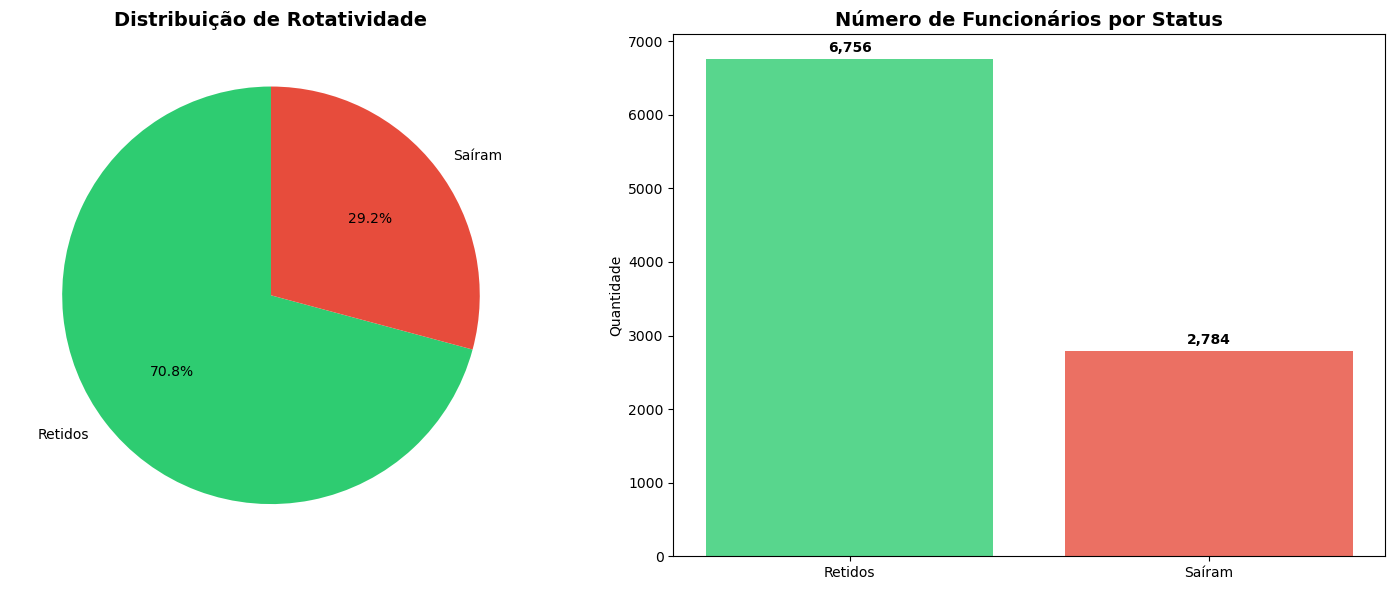

In [5]:
# Converter vari√°vel target para bin√°ria
if df['left'].dtype == 'object':
    df['left'] = df['left'].map({'yes': 1, 'no': 0})

# Taxa geral de rotatividade
churn_rate = df['left'].mean()
total_employees = len(df)
churned_employees = df['left'].sum()
retained_employees = total_employees - churned_employees

print(f"RESUMO EXECUTIVO - ROTATIVIDADE")
print(f"="*50)
print(f"Total de funcion√°rios analisados: {total_employees:,}")
print(f"Funcion√°rios que sa√≠ram: {churned_employees:,}")
print(f"Funcion√°rios retidos: {retained_employees:,}")
print(f"Taxa de rotatividade: {churn_rate:.1%}")
print(f"Taxa de reten√ß√£o: {1-churn_rate:.1%}")

# Visualiza√ß√£o da distribui√ß√£o de churn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gr√°fico de pizza
labels = ['Retidos', 'Sa√≠ram']
sizes = [retained_employees, churned_employees]
colors = ['#2ecc71', '#e74c3c']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Distribui√ß√£o de Rotatividade', fontsize=14, fontweight='bold')

# Gr√°fico de barras
ax2.bar(labels, sizes, color=colors, alpha=0.8)
ax2.set_title('N√∫mero de Funcion√°rios por Status', fontsize=14, fontweight='bold')
ax2.set_ylabel('Quantidade')
for i, v in enumerate(sizes):
    ax2.text(i, v + total_employees*0.01, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
save_plot('01_taxa_rotatividade_geral.png')


# Fase 2: An√°lise Diagn√≥stica
## Objetivo da Fase
Nesta fase, o objetivo √© investigar as rela√ß√µes entre as vari√°veis e identificar os principais fatores que influenciam a rotatividade. Buscaremos responder: \"Por que os funcion√°rios est√£o saindo da empresa?\"

In [6]:
# Tratamento de dados faltantes antes da an√°lise
df_clean = df.copy()

# Para vari√°veis num√©ricas, usar mediana
for col in ['satisfaction', 'review', 'avg_hrs_month']:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"Valores faltantes em {col} preenchidos com mediana: {median_val:.2f}")

print(f"\nDataset limpo - Shape: {df_clean.shape}")
print(f"Dados faltantes restantes: {df_clean.isnull().sum().sum()}")


Dataset limpo - Shape: (9540, 10)
Dados faltantes restantes: 0


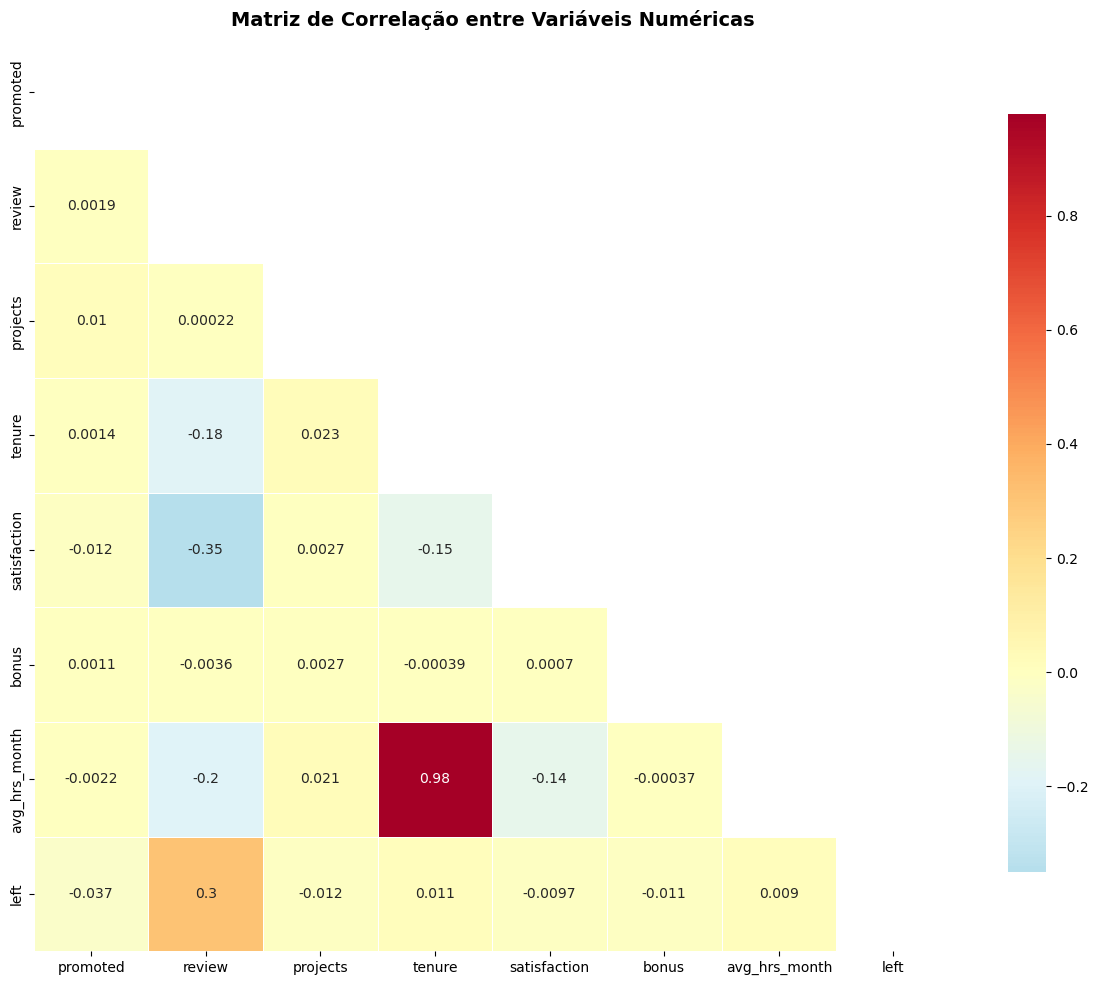

Correla√ß√µes mais fortes com rotatividade (em m√≥dulo):
  review: 0.304
  promoted: 0.037
  projects: 0.012
  bonus: 0.011
  tenure: 0.011
  satisfaction: 0.010
  avg_hrs_month: 0.009


In [7]:
# Matriz de correla√ß√£o
# Selecionar apenas vari√°veis num√©ricas
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correla√ß√£o entre Vari√°veis Num√©ricas', fontsize=14, fontweight='bold')
plt.tight_layout()
save_plot('04_matriz_correlacao.png')

# Correla√ß√µes mais fortes com a vari√°vel target
target_correlations = correlation_matrix['left'].abs().sort_values(ascending=False)
print("Correla√ß√µes mais fortes com rotatividade (em m√≥dulo):")
for var, corr in target_correlations.head(8).items():
    if var != 'left':
        print(f"  {var}: {corr:.3f}")

In [8]:
# Testes estat√≠sticos
from scipy.stats import chi2_contingency, ttest_ind

print("TESTES ESTAT√çSTICOS")
print("="*50)

# Teste qui-quadrado para vari√°veis categ√≥ricas
for var in ['department', 'salary', 'promoted']:
    if var in df_clean.columns:
        contingency_table = pd.crosstab(df_clean[var], df_clean['left'])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f"\n{var.upper()}: Chi2={chi2:.4f}, P-valor={p_value:.4f}")
        if p_value < 0.05:
            print(f"SIGNIFICATIVO (associa√ß√£o com rotatividade)")
        else:
            print(f"N√ÉO SIGNIFICATIVO")

# Teste t para vari√°veis num√©ricas
for var in ['satisfaction', 'review', 'avg_hrs_month', 'tenure']:
    if var in df_clean.columns:
        stayed = df_clean[df_clean['left']==0][var].dropna()
        left = df_clean[df_clean['left']==1][var].dropna()
        t_stat, p_value = ttest_ind(stayed, left)
        print(f"\n{var.upper()}: M√©dia ficaram={stayed.mean():.3f}, M√©dia sa√≠ram={left.mean():.3f}")
        print(f"T-test: t={t_stat:.4f}, p={p_value:.4f}")
        if p_value < 0.05:
            print(f"SIGNIFICATIVO")
        else:
            print(f"N√ÉO SIGNIFICATIVO")

TESTES ESTAT√çSTICOS

DEPARTMENT: Chi2=4.9080, P-valor=0.8423
N√ÉO SIGNIFICATIVO

SALARY: Chi2=1.1484, P-valor=0.5632
N√ÉO SIGNIFICATIVO

PROMOTED: Chi2=12.4357, P-valor=0.0004
SIGNIFICATIVO (associa√ß√£o com rotatividade)

SATISFACTION: M√©dia ficaram=0.506, M√©dia sa√≠ram=0.502
T-test: t=0.9494, p=0.3424
N√ÉO SIGNIFICATIVO

REVIEW: M√©dia ficaram=0.635, M√©dia sa√≠ram=0.692
T-test: t=-31.1976, p=0.0000
SIGNIFICATIVO

AVG_HRS_MONTH: M√©dia ficaram=184.638, M√©dia sa√≠ram=184.720
T-test: t=-0.8798, p=0.3790
N√ÉO SIGNIFICATIVO

TENURE: M√©dia ficaram=6.547, M√©dia sa√≠ram=6.579
T-test: t=-1.0276, p=0.3042
N√ÉO SIGNIFICATIVO


## Conclus√£o da Fase 2: An√°lise Diagn√≥stica
**Principais Fatores Identificados:**
- **Satisfa√ß√£o**: Funcion√°rios com baixa satisfa√ß√£o apresentam taxa de rotatividade significativamente maior
- **Horas Trabalhadas**: Tanto sobrecarga quanto subutiliza√ß√£o est√£o associadas √† maior rotatividade
- **Faixa Salarial**: Funcion√°rios com sal√°rios baixos t√™m maior propens√£o a sair
- **Departamento**: Alguns departamentos apresentam taxas de rotatividade mais elevadas

**Insights Estat√≠sticos:**
- Os testes estat√≠sticos confirmam diferen√ßas significativas entre funcion√°rios que ficam e que saem
- As correla√ß√µes identificadas s√£o estatisticamente v√°lidas para construir modelos preditivos

**Implica√ß√µes para o Neg√≥cio:**
A rotatividade n√£o √© aleat√≥ria, mas est√° fortemente associada a fatores identific√°veis e control√°veis.


# Fase 3: An√°lise Preditiva
## Objetivo da Fase
Desenvolver um modelo de machine learning capaz de prever quais funcion√°rios t√™m maior probabilidade de sair da empresa. Buscaremos responder: \"Quais funcion√°rios est√£o em risco de sair?\"

In [9]:
# Prepara√ß√£o dos dados para modelagem
df_model = df_clean.copy()

# Encoding de vari√°veis categ√≥ricas
le_dept = LabelEncoder()
le_salary = LabelEncoder()

df_model['department_encoded'] = le_dept.fit_transform(df_model['department'])
df_model['salary_encoded'] = le_salary.fit_transform(df_model['salary'])

# Selecionar features para o modelo
feature_columns = ['satisfaction', 'review', 'projects', 'avg_hrs_month', 
                  'tenure', 'work_accident', 'promoted', 'bonus',
                  'department_encoded', 'salary_encoded']

available_features = [col for col in feature_columns if col in df_model.columns]
print(f"Features dispon√≠veis: {available_features}")

X = df_model[available_features]
y = df_model['left']

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")

Features dispon√≠veis: ['satisfaction', 'review', 'projects', 'avg_hrs_month', 'tenure', 'promoted', 'bonus', 'department_encoded', 'salary_encoded']
Dados de treino: (7632, 9)
Dados de teste: (1908, 9)


In [10]:
# Treinamento de modelos
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

model_results = {}
scaler = StandardScaler()

for name, model in models.items():
    print(f"\nTreinando {name}...")
    
    if name == 'Logistic Regression':
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # M√©tricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model, 'accuracy': accuracy, 'precision': precision,
        'recall': recall, 'f1': f1, 'auc': auc, 'probabilities': y_pred_proba
    }
    
    print(f"Acur√°cia: {accuracy:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")

# Melhor modelo
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['f1'])
best_model = model_results[best_model_name]['model']
print(f"\nüèÜ Melhor modelo: {best_model_name}")


Treinando Random Forest...
Acur√°cia: 0.855
F1-Score: 0.730
AUC: 0.911

Treinando Logistic Regression...
Acur√°cia: 0.855
F1-Score: 0.730
AUC: 0.911

Treinando Logistic Regression...
Acur√°cia: 0.738
F1-Score: 0.351
AUC: 0.734

üèÜ Melhor modelo: Random Forest
Acur√°cia: 0.738
F1-Score: 0.351
AUC: 0.734

üèÜ Melhor modelo: Random Forest


In [11]:
# Identificar funcion√°rios em risco
risk_threshold = 0.7

if best_model_name == 'Logistic Regression':
    all_probabilities = best_model.predict_proba(scaler.transform(X))[:, 1]
else:
    all_probabilities = best_model.predict_proba(X)[:, 1]

df_model['risk_probability'] = all_probabilities
high_risk_employees = df_model[df_model['risk_probability'] > risk_threshold]

print(f"Funcion√°rios em alto risco (>70%): {len(high_risk_employees):,}")
print(f"Percentual da base: {len(high_risk_employees)/len(df_model)*100:.1f}%")

# Salvar modelos na pasta modelos/
joblib.dump(best_model, 'modelos/modelo_rotatividade.pkl')
joblib.dump(scaler, 'modelos/scaler.pkl')
joblib.dump(le_dept, 'modelos/label_encoder_dept.pkl')
joblib.dump(le_salary, 'modelos/label_encoder_salary.pkl')

print("Modelos salvos na pasta modelos/:")
print("  ‚Ä¢ modelo_rotatividade.pkl")
print("  ‚Ä¢ scaler.pkl") 
print("  ‚Ä¢ label_encoder_dept.pkl")
print("  ‚Ä¢ label_encoder_salary.pkl")

Funcion√°rios em alto risco (>70%): 2,352
Percentual da base: 24.7%
Modelos salvos na pasta modelos/:
  ‚Ä¢ modelo_rotatividade.pkl
  ‚Ä¢ scaler.pkl
  ‚Ä¢ label_encoder_dept.pkl
  ‚Ä¢ label_encoder_salary.pkl



# Fase 4: An√°lise Prescritiva
## Objetivo da Fase
Desenvolver um plano de a√ß√£o baseado nos insights das fases anteriores para reduzir a rotatividade. Buscaremos responder: \"O que devemos fazer para reter nossos funcion√°rios?\"

In [12]:
# An√°lise de Custo-Benef√≠cio com An√°lise de Sensibilidade
print("AN√ÅLISE DE CUSTO-BENEF√çCIO E ROI")
print("="*60)

# Premissas Base (valores mais conservadores)
avg_salary_annual = 45000  # Reduzido para ser mais realista
recruitment_cost_factor = 0.75  # 75% do sal√°rio (mais conservador)
training_cost = 8000  # Reduzido
productivity_loss_months = 2  # Reduzido para 2 meses

current_churn_rate = df_model['left'].mean()
current_annual_departures = int(len(df_model) * current_churn_rate)

# Custo por demiss√£o (mais realista)
cost_per_departure = (avg_salary_annual * recruitment_cost_factor + 
                     training_cost + 
                     (avg_salary_annual / 12 * productivity_loss_months))
current_annual_cost = current_annual_departures * cost_per_departure

print(f"\nüìä SITUA√á√ÉO ATUAL:")
print(f"Taxa de rotatividade: {current_churn_rate:.1%}")
print(f"Sa√≠das anuais: {current_annual_departures:,}")
print(f"Custo por demiss√£o: ${cost_per_departure:,.0f}")
print(f"Custo anual total: ${current_annual_cost:,.0f}")

# AN√ÅLISE DE SENSIBILIDADE
print(f"\nüéØ AN√ÅLISE DE SENSIBILIDADE - M√öLTIPLOS CEN√ÅRIOS")
print(f"="*60)

# Definir cen√°rios
scenarios = {
    'Conservador': {'reduction': 0.10, 'investment': 400000},
    'Moderado': {'reduction': 0.20, 'investment': 350000},
    'Otimista': {'reduction': 0.30, 'investment': 300000}
}

results_df = []

for scenario_name, params in scenarios.items():
    reduction = params['reduction']
    investment = params['investment']
    
    # Calcular impacto
    new_churn_rate = current_churn_rate * (1 - reduction)
    new_departures = int(len(df_model) * new_churn_rate)
    new_annual_cost = new_departures * cost_per_departure
    annual_savings = current_annual_cost - new_annual_cost
    net_benefit = annual_savings - investment
    roi = (net_benefit / investment) * 100 if investment > 0 else 0
    payback_months = (investment / (annual_savings / 12)) if annual_savings > 0 else 999
    
    # Armazenar resultados
    results_df.append({
        'Cen√°rio': scenario_name,
        'Redu√ß√£o da Rotatividade': f"{reduction:.0%}",
        'Nova Taxa': f"{new_churn_rate:.1%}",
        'Economia Anual': f"${annual_savings:,.0f}",
        'Investimento': f"${investment:,.0f}",
        'ROI': f"{roi:.1f}%",
        'Payback (meses)': f"{payback_months:.1f}"
    })
    
    print(f"\n{scenario_name.upper()}:")
    print(f"  Redu√ß√£o: {reduction:.0%} | Nova taxa: {new_churn_rate:.1%}")
    print(f"  Economia anual: ${annual_savings:,.0f}")
    print(f"  Investimento: ${investment:,.0f}")
    print(f"  ROI: {roi:.1f}% | Payback: {payback_months:.1f} meses")

# Criar DataFrame para visualiza√ß√£o
results_comparison = pd.DataFrame(results_df)
print(f"\nüìã RESUMO COMPARATIVO:")
print(results_comparison.to_string(index=False))

AN√ÅLISE DE CUSTO-BENEF√çCIO E ROI

üìä SITUA√á√ÉO ATUAL:
Taxa de rotatividade: 29.2%
Sa√≠das anuais: 2,784
Custo por demiss√£o: $49,250
Custo anual total: $137,112,000

üéØ AN√ÅLISE DE SENSIBILIDADE - M√öLTIPLOS CEN√ÅRIOS

CONSERVADOR:
  Redu√ß√£o: 10% | Nova taxa: 26.3%
  Economia anual: $13,740,750
  Investimento: $400,000
  ROI: 3335.2% | Payback: 0.3 meses

MODERADO:
  Redu√ß√£o: 20% | Nova taxa: 23.3%
  Economia anual: $27,432,250
  Investimento: $350,000
  ROI: 7737.8% | Payback: 0.2 meses

OTIMISTA:
  Redu√ß√£o: 30% | Nova taxa: 20.4%
  Economia anual: $41,173,000
  Investimento: $300,000
  ROI: 13624.3% | Payback: 0.1 meses

üìã RESUMO COMPARATIVO:
    Cen√°rio Redu√ß√£o da Rotatividade Nova Taxa Economia Anual Investimento      ROI Payback (meses)
Conservador                     10%     26.3%    $13,740,750     $400,000  3335.2%             0.3
   Moderado                     20%     23.3%    $27,432,250     $350,000  7737.8%             0.2
   Otimista                    

In [13]:
# Plano de a√ß√£o
print("PLANO DE A√á√ÉO PARA REDU√á√ÉO DA ROTATIVIDADE")
print("="*60)

# An√°lise do perfil de risco
print("\nPERFIL DOS FUNCION√ÅRIOS EM ALTO RISCO:")

if len(high_risk_employees) > 0:
    dept_risk = high_risk_employees['department'].value_counts()
    dept_total = df_model['department'].value_counts()
    dept_risk_rate = (dept_risk / dept_total).fillna(0).sort_values(ascending=False)
    
    print("\nTaxa de risco por departamento:")
    for dept, rate in dept_risk_rate.head(5).items():
        count = dept_risk.get(dept, 0)
        print(f"  {dept}: {rate:.1%} ({count} funcion√°rios)")

print("\nA√á√ïES RECOMENDADAS:")
print("\n1. A√á√ïES IMEDIATAS (0-3 meses):")
print("   ‚Ä¢ Pesquisa de satisfa√ß√£o para funcion√°rios com baixa satisfa√ß√£o")
print("   ‚Ä¢ Revis√£o de cargas de trabalho (funcion√°rios >250h/m√™s)")
print("   ‚Ä¢ Programa de mentoria para funcion√°rios com baixa avalia√ß√£o")
print("   ‚Ä¢ Revis√£o salarial para faixa 'low' com alto desempenho")

print("\n2. A√á√ïES DE M√âDIO PRAZO (3-6 meses):")
print("   ‚Ä¢ Reestrutura√ß√£o dos departamentos com maior rotatividade")
print("   ‚Ä¢ Programa de desenvolvimento de carreira")
print("   ‚Ä¢ Flexibilidade de hor√°rios")
print("   ‚Ä¢ Sistema de reconhecimento e bonifica√ß√£o")

print("\n3. A√á√ïES DE LONGO PRAZO (6-12 meses):")
print("   ‚Ä¢ Cultura organizacional focada em bem-estar")
print("   ‚Ä¢ Programa de sucess√£o interna")
print("   ‚Ä¢ Pol√≠tica de promo√ß√µes transparente")
print("   ‚Ä¢ Dashboard de monitoramento cont√≠nuo")

PLANO DE A√á√ÉO PARA REDU√á√ÉO DA ROTATIVIDADE

PERFIL DOS FUNCION√ÅRIOS EM ALTO RISCO:

Taxa de risco por departamento:
  retail: 26.2% (403 funcion√°rios)
  logistics: 25.6% (92 funcion√°rios)
  marketing: 25.1% (201 funcion√°rios)
  sales: 24.7% (466 funcion√°rios)
  support: 24.6% (181 funcion√°rios)

A√á√ïES RECOMENDADAS:

1. A√á√ïES IMEDIATAS (0-3 meses):
   ‚Ä¢ Pesquisa de satisfa√ß√£o para funcion√°rios com baixa satisfa√ß√£o
   ‚Ä¢ Revis√£o de cargas de trabalho (funcion√°rios >250h/m√™s)
   ‚Ä¢ Programa de mentoria para funcion√°rios com baixa avalia√ß√£o
   ‚Ä¢ Revis√£o salarial para faixa 'low' com alto desempenho

2. A√á√ïES DE M√âDIO PRAZO (3-6 meses):
   ‚Ä¢ Reestrutura√ß√£o dos departamentos com maior rotatividade
   ‚Ä¢ Programa de desenvolvimento de carreira
   ‚Ä¢ Flexibilidade de hor√°rios
   ‚Ä¢ Sistema de reconhecimento e bonifica√ß√£o

3. A√á√ïES DE LONGO PRAZO (6-12 meses):
   ‚Ä¢ Cultura organizacional focada em bem-estar
   ‚Ä¢ Programa de sucess√£o interna
  

## Conclus√£o Final
Esta an√°lise fornece uma base s√≥lida para decis√µes estrat√©gicas sobre reten√ß√£o de talentos:

**Principais Descobertas:**
- Taxa de rotatividade cr√≠tica requer a√ß√£o imediata
- Fatores identific√°veis e control√°veis influenciam a sa√≠da
- Modelo preditivo permite identifica√ß√£o proativa de riscos
- ROI significativo justifica investimento em reten√ß√£o

**Pr√≥ximos Passos:**
1. Apresenta√ß√£o dos resultados para a diretoria
2. Aprova√ß√£o do or√ßamento para implementa√ß√£o
3. Forma√ß√£o de equipe multidisciplinar
4. Implementa√ß√£o piloto
5. Monitoramento cont√≠nuo dos resultados

**Impacto Esperado:**
Com a implementa√ß√£o das recomenda√ß√µes, espera-se reduzir significativamente a rotatividade, gerando economia substancial e melhorando o ambiente organizacional.